In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import inspect,func

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base=automap_base()

# reflect the tables
base.prepare(engine, reflect=True)


In [6]:
base.classes


In [7]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement=base.classes.measurement
station=base.classes.station

In [9]:
# Create our session (link) from Python to the DB Starts the session
session=Session(engine)

# Exploratory Precipitation Analysis

In [10]:
session.query(measurement.date)

In [11]:
lateststrA = session.query(measurement.date).order_by(measurement.date.desc())

In [12]:
print(lateststrA)

SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC


In [13]:
# Find the most recent date in the data set.
lateststr = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"Latest: {lateststr[0]}")

Latest: 2017-08-23


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

latestdate= dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
print(latestdate)

# Calculate the date one year from the last date in data set.
year_ago=dt.date(latestdate.year -1, latestdate.month, latestdate.day)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
sel_query=[measurement.date, measurement.prcp]
query_sel=session.query(*sel_query).filter(measurement.date>=year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation=pd.DataFrame(query_sel, columns=['Date','Precipitation'])
precipitation=precipitation.dropna()
precipitation = precipitation.set_index("Date")


# Sort the dataframe by date
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation

# Use Pandas Plotting with Matplotlib to plot the data

2017-08-23 00:00:00
2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


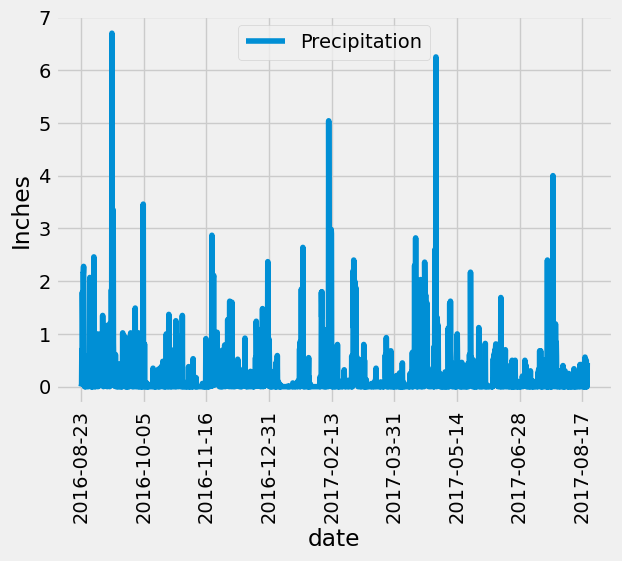

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

precipitation.plot(rot=90)
plt.xlabel("date")
plt.ylabel("Inches")
plt.show()


In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data

precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
#Finding columns and datatype
inspectorA = inspect(engine)
columns = inspectorA.get_columns('measurement')
for each in columns:
    print(each['name'], each["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
#Finding columns and datatype
inspector = inspect(engine)
columns = inspector.get_columns('station')
for each in columns:
    print(each['name'], each["type"])
    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(func.count(station.id)).all()
station_count

ms=session.query(measurement.station)

In [20]:
print(ms)

SELECT measurement.station AS measurement_station 
FROM measurement


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
#name of station
#count of each station
#groupby station
#order by count largest to smallest
station_Measurment_join=session.query(measurement.station,func.count(measurement.station)).\
                       group_by(measurement.station).\
                       order_by(func.count(measurement.station).desc()).all()
station_Measurment_join


# List the stations and their counts in descending order.



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results_temp=session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
             filter(measurement.station==station_Measurment_join[0][0]).all()
results_temp

[(54.0, 85.0, 71.66378066378067)]

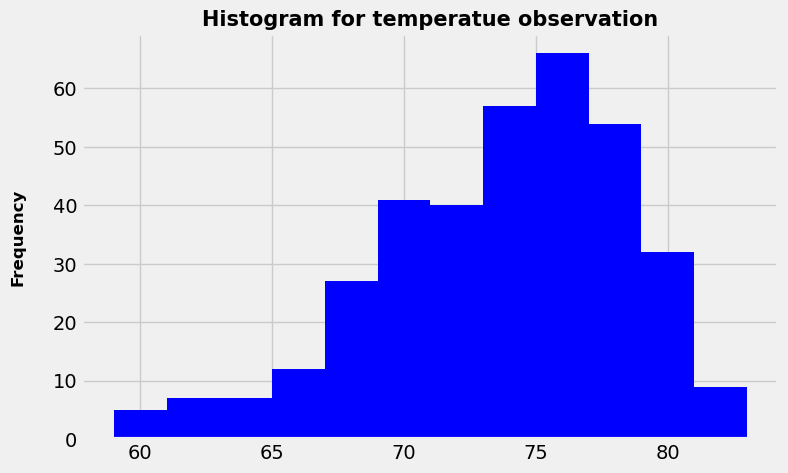

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_date=session.query(measurement.date).order_by(measurement.date.desc()).\
             filter(measurement.station==station_Measurment_join[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_temp=session.query(measurement.tobs).\
             filter(measurement.station==station_Measurment_join[0][0]).\
             filter(measurement.date>=year_back).all()
df_results=pd.DataFrame(results_temp)


#Plotting Histogram
hist = df_results['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)

# Remove title
hist.set_title("Histogram for temperatue observation",weight='bold', size=15)

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

plt.show()


# Close Session

In [24]:
# Close Session
session.close()